In [196]:
import pandas as pd
import numpy as np

data_cu_2=pd.read_csv('../Data/01_Courses_usagers/2023_02/All_data_courses.csv', sep=";")
data_remp_2=pd.read_csv('../Data/02_Historique_remplissage_stations/2023_02/All_data_remplissage.csv', sep=",")
data_mouv_2=pd.read_excel('../Data/03_Régulation_mouvements_stations/2023_02/2023-02-01_Mouvements_de_régulation.xlsx')
data_remp_2.head()

,code_station,station_name,longitude,latitude,Date_Update,VM_Av,VAE_AV,VM_Unav,VAE_Unav,Nb_Diap_av,VM_av_StatPlus,VAE_av_StatPlus,VM_Unav.1,VAE_Unav.1,Cable_av
0,1001,Quai de l'Horloge - Pont Neuf,2.341798,48.857059,2023-02-01 00:00:00,1,0,0,0,16,0,0,0,0,NaN
1,1001,Quai de l'Horloge - Pont Neuf,2.341798,48.857059,2023-02-01 00:02:00,1,0,1,0,15,0,0,0,0,NaN
2,1001,Quai de l'Horloge - Pont Neuf,2.341798,48.857059,2023-02-01 03:25:00,1,1,1,0,14,0,0,0,0,NaN
3,1001,Quai de l'Horloge - Pont Neuf,2.341798,48.857059,2023-02-01 06:15:00,1,0,1,0,15,0,0,0,0,NaN
4,1001,Quai de l'Horloge - Pont Neuf,2.341798,48.857059,2023-02-01 06:29:00,1,1,1,0,14,0,0,0,0,NaN


Ici je détermine le taux de remplissage moyen par station en supposant que la capicité totale est le nombre de dispo+indispo

In [169]:
data_remp_2['dispo']=data_remp_2['VM_Av']+data_remp_2['VAE_AV']
data_remp_2['indis']=data_remp_2['VM_Unav']+data_remp_2['VAE_Unav']+data_remp_2['VAE_Unav.1']
data_remp_2['occ']=data_remp_2['dispo'] / (data_remp_2['dispo']+data_remp_2['indis'])

In [170]:
occupation=data_remp_2.groupby('station_name')['occ'].mean().reset_index()
occupation.sort_values(by=['occ'])

,station_name,occ
79,Batignolles - Rome,0.608584
1159,Raymond Poincaré - Place Victor Hugo,0.629632
187,Ceinture du Lac Inferieure - Saint-Cloud,0.655688
372,Etienne Jodelle - Saint Ouen,0.664400
989,Place Jean-Baptiste Clément,0.673350
...,...,...
810,Maxime Gorki - Louis Aragon,0.993166
1311,Stalingrad - Henri Luisette,0.994103
895,Parc de Sceaux - Centre-Ville,0.995367
131,Borrégo - Gambetta,0.998550


Ici je repère quel est le jour le moins actif et quelle est l'heure la moins active. Une date de départ et une date d'arrivée content chaque comme 1 activité

In [171]:
data_cu_2['date_depart'] = pd.to_datetime(data_cu_2['date_depart'])
data_cu_2['date_arrive'] = pd.to_datetime(data_cu_2['date_arrive'])

# Concaténer les deux colonnes pour obtenir toutes les activités dans une seule série
all_activities = pd.concat([data_cu_2['date_depart'], data_cu_2['date_arrive']])

# Extraire l'heure de chaque activité
all_activities_hour = all_activities.dt.hour

# Trouver l'heure la moins fréquente
min_hour = all_activities_hour.value_counts().idxmin()

# Extraire le jour de chaque activité
all_activities_day = all_activities.dt.date

# Trouver le jour le moins fréquent
min_day = all_activities_day.value_counts().idxmin()

print("Moment de la journée avec le moins d'activité:", min_hour, "h00")
print("Journée avec le moins d'activité:", min_day)

Moment de la journée avec le moins d'activité: 4 h00
Journée avec le moins d'activité: 2022-11-05


Création d'un dataframe indiquant le nombre de départ et le nombre d'arrivées par station

In [172]:
# Compter le nombre de départs par station
depart_counts = data_cu_2['from_stat'].value_counts()

# Compter le nombre d'arrivées par station
arrivee_counts = data_cu_2['to_stat'].value_counts()

# Créer un dataframe avec les stations, le nombre de départs et le nombre d'arrivées
activite_station = pd.DataFrame({
    'Station': depart_counts.index,
    'Nb_departs': depart_counts.values,
    'Nb_arrivees': arrivee_counts.reindex(depart_counts.index, fill_value=0).values
})

activite_station['remplissage']=activite_station['Nb_arrivees']-activite_station['Nb_departs'] #correspond au nombre de vélos en + ou en - sur 6 mois
activite_station

,Station,Nb_departs,Nb_arrivees,remplissage
0,Gare Saint-Lazare - Cour du Havre,10057,10137,80
1,Gare de Lyon - Place Louis Armand,9785,9866,81
2,Richard Lenoir - Place de la Bastille,9659,9574,-85
3,Place Mireille Havet,9042,8904,-138
4,Petites Ecuries - Faubourg Saint-Denis,8188,8089,-99
...,...,...,...,...
1421,Combox Volante - atelier villeneuve,3,0,-3
1422,Stade Pershing,2,2,0
1423,station formation alfortville,1,0,-1
1424,Saint-Germain - Verdun,1,0,-1


Idée: faire des couples de stations avec une en remplissage négatif et une remplissage positive. Les couples seront formés en fonction de leur distance où la distance corrospond à la latitude, la longitude et la valeur absolue de remplissage; avec ces 3 données centrées réduites. Il faut adapter le code pour avoir un remplissage celon le type de vélo. Problème: si une station à un remplissage négatif pour les vélos électriques et positif pour les autres vélos, il faut faire un aller-retour. Solution former des couples par type de vélo. Remarque: la latitude et la longitude ne sont pas des bons représentatifs de distance car les navettes ne se déplacent pas en distance euclidienne, la durée et la distance parcourue peuvent donner un meilleur apercu de la distance à parcourir par la navette.

In [173]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance_matrix

features=['remplissage', 'Latitude station prise', 'Longitude station prise']
# Séparer les stations en fonction du remplissage
stations_remplissage = activite_station[activite_station['remplissage'] > 0].copy()
stations_vidage = activite_station[activite_station['remplissage'] < 0].copy()
stations_vidage['remplissage']=np.abs(stations_vidage['remplissage'])

In [174]:
stations = data_cu_2.loc[:, ['from_stat', 'Latitude_start', 'longitude_start']].drop_duplicates().reset_index(drop=True)
stations = stations.rename(columns={'from_stat': 'nom', 'Latitude_start': 'latitude', 'longitude_start': 'longitude'})
stations

,nom,latitude,longitude
0,Jean Moulin - Paul Doumer,48.862218,2.455334
1,Lucie Aubrac - Franklin,48.862239,2.443586
2,Docteurs Déjérine - Pte de Montreuil,48.853984,2.412083
3,Jules Vallès - Charonne,48.854284,2.384767
4,Gare de l'Est - Place du 11 Novembre 1918,48.876327,2.358546
...,...,...,...
1466,Quai Panhard et Levassor,48.828167,2.384425
1467,Ney - Porte de Montmartre,48.897921,2.336836
1468,Jean Macé - Faidherbe,48.852860,2.383449
1469,Centenaire - Sorins,48.857917,2.427114


In [186]:
stations_remplissage.remplissage.sum()

992

Dans la suite du problème il est important que les sommes des fréquences de remplissage s'équilibrent pour faire 0

In [175]:
stations_remplissage = stations_remplissage.sample(n=15)
n = stations_remplissage.remplissage.sum()

stations_vidage2 = pd.DataFrame(columns=stations_vidage.columns)

while stations_vidage2.remplissage.sum() != n:
    while stations_vidage2['remplissage'].sum() < n:
        stations_vidage2 = pd.concat([stations_vidage2, stations_vidage.sample(1)], ignore_index=True)
        
    while stations_vidage2.remplissage.sum() > n:
        stations_vidage2 = stations_vidage2.drop(stations_vidage2.sample(1).index)

stations_vidage=stations_vidage2
stations_remplissage=stations_remplissage.reset_index(drop=True)
stations_vidage=stations_vidage.reset_index(drop=True)

In [176]:
stations_remplissage.remplissage.sum(), stations_remplissage.remplissage.sum()

(992, 992)

In [177]:
pos_station_vidage = stations.loc[stations['nom'].isin(stations_vidage['Station']), :]
pos_station_remplissage = stations.loc[stations['nom'].isin(stations_remplissage['Station']), :]

pos_station_remplissage=pos_station_remplissage.drop_duplicates(subset=['nom']).reset_index(drop=True)
pos_station_vidage=pos_station_vidage.drop_duplicates(subset=['nom']).reset_index(drop=True)

pos_station_vidage

,nom,latitude,longitude
0,Porte d'Ivry,48.821769,2.368871
1,Mathurins - Auber,48.872989,2.329498
2,Jean-Baptiste Charcot - Sainte-Geneviève,48.903109,2.278893
3,Flandre - Riquet,48.888013,2.373760
4,Crozatier - Faubourg Saint-Antoine,48.850440,2.378901
5,Gare de l'Est - Faubourg-Saint-Martin,48.875643,2.359459
6,Croix Nivert - Square Saint-Lambert,48.843052,2.295200
7,Exelmans - Versailles,48.840975,2.264390
8,Sainte-Elisabeth - Turbigo,48.866103,2.359649
9,Route de Sèvres - Porte de Bagatelle,48.875260,2.249416


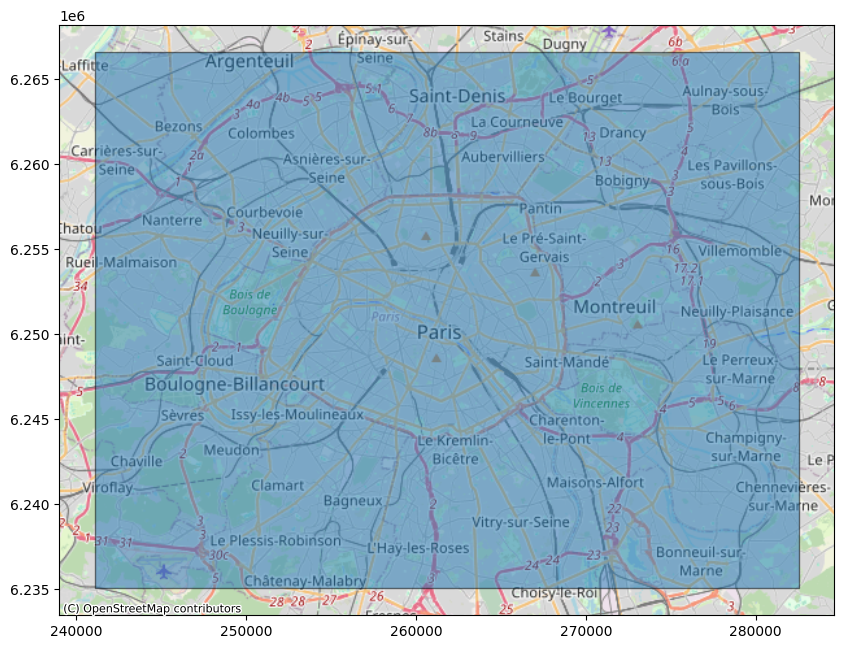

In [178]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as pl
from shapely.geometry import box

bbox = (stations.longitude.min(), stations.latitude.min(), stations.longitude.max(), stations.latitude.max())
geometry = [box(*bbox)]
gdf = gpd.GeoDataFrame({'geometry': geometry}, crs="EPSG:4326")
gdf = gdf.to_crs(epsg=3857)
ax = gdf.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
pl.savefig('paris_map.png')
pl.show()

Text(0.5, 1.0, 'stations de vélos')

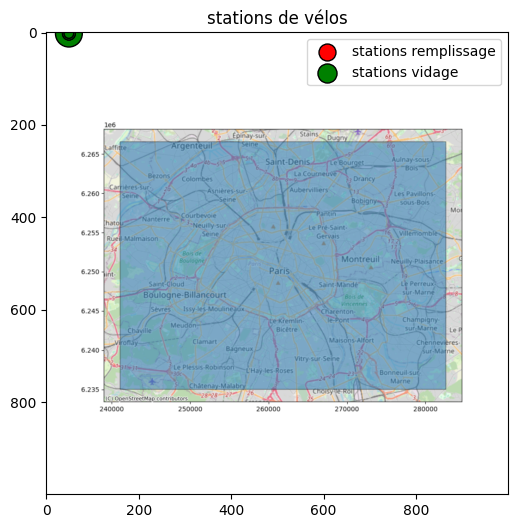

In [179]:
import pylab as pl
import ot
import time
import matplotlib.image as mpimg

r_remplissage=pd.to_numeric(stations_remplissage['remplissage'])
v_remplissage=pd.to_numeric(stations_vidage['remplissage'])
lat_remplissage=pos_station_remplissage['latitude'].values
long_remplissage=pos_station_remplissage['longitude'].values
lat_vidage=pos_station_vidage['latitude'].values
long_vidage=pos_station_vidage['longitude'].values

paris_map = mpimg.imread('paris_map.png')
pl.figure(1,(7,6))
pl.clf()
pl.imshow(paris_map, interpolation='bilinear')
pl.scatter(lat_remplissage, long_remplissage, s=r_remplissage, c='red', ec='k', label='stations remplissage')
pl.scatter(lat_vidage, long_vidage, s=v_remplissage, c='green', ec='k', label='stations vidage')
pl.legend()
pl.title('stations de vélos')

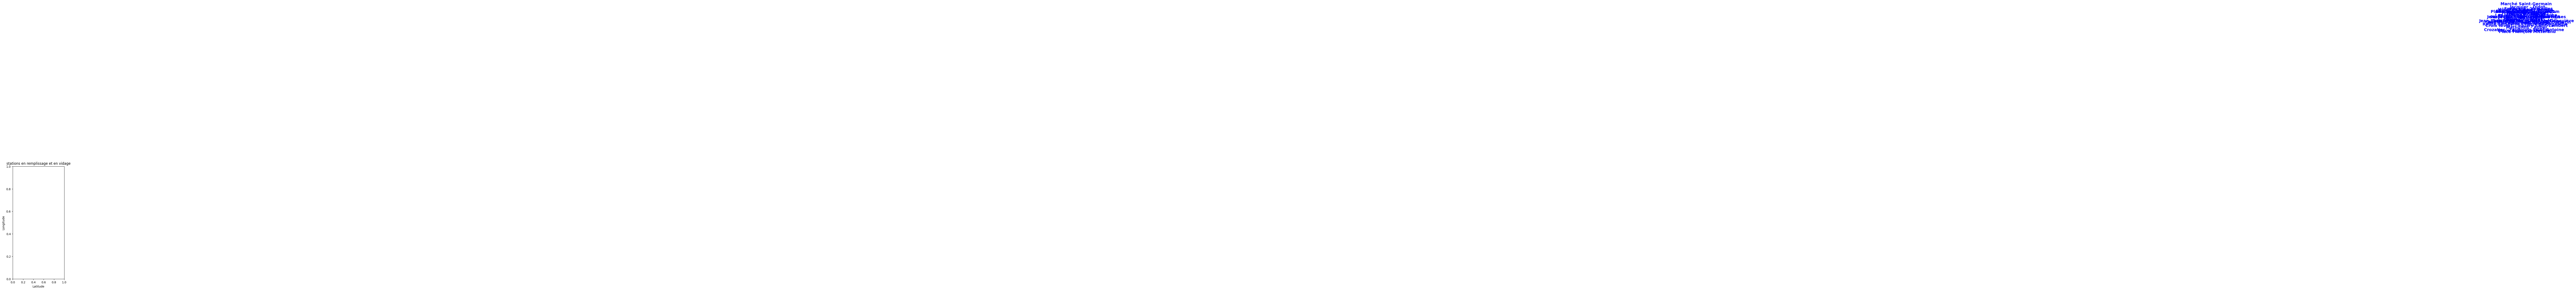

In [180]:
C = ot.dist(pos_station_remplissage[['latitude','longitude']].values, pos_station_vidage[['latitude','longitude']].values)

f1 = pl.figure(1, (7,7))
pl.clf()
pl.subplot(121)
#pl.imshow(Imap, interpolation='bilinear')
for i in range(len(stations_vidage)):
    pl.text(pos_station_vidage.loc[i, 'latitude'], pos_station_vidage.loc[i, 'longitude'], stations_vidage.Station[i], color='blue', fontsize=14, fontweight='bold', ha='center', va='center')
for i in range(len(stations_remplissage)):
    pl.text(pos_station_remplissage.loc[i, 'latitude'], pos_station_remplissage.loc[i, 'longitude'], stations_remplissage.Station[i], color='blue', fontsize=14, fontweight='bold', ha='center', va='center')
pl.title('stations en remplissage et en vidage')
pl.xlabel('Latitude')
pl.ylabel('Longitude')
pl.show()

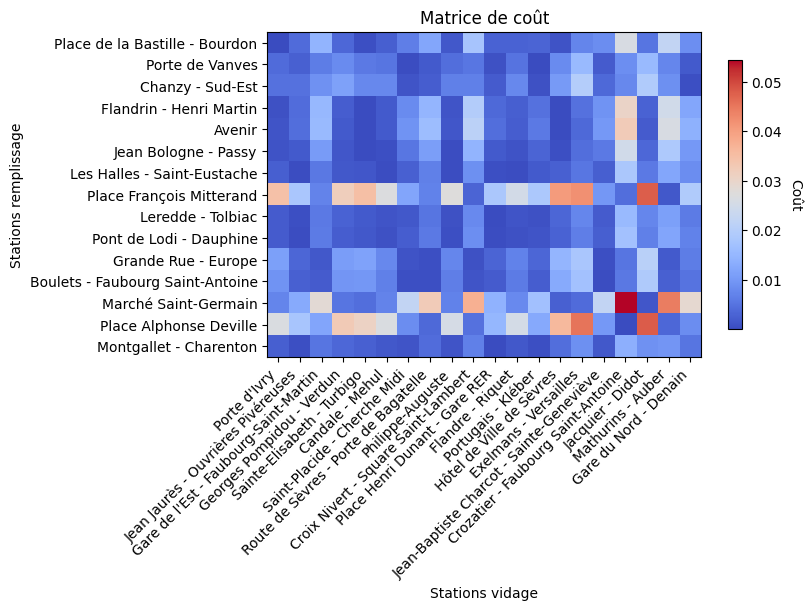

In [181]:
f2 = pl.figure(2, (7, 7))
pl.clf()
im = pl.imshow(C, cmap='coolwarm')
pl.title('Matrice de coût')
pl.xticks(ticks=np.arange(len(stations_vidage)), labels=stations_vidage['Station'], rotation=45, ha='right')
pl.yticks(ticks=np.arange(len(stations_remplissage)), labels=stations_remplissage['Station'])
cbar = pl.colorbar(im, shrink=0.5)
cbar.ax.set_ylabel("Coût", rotation=-90, va="bottom")
pl.xlabel('Stations vidage')
pl.ylabel('Stations remplissage')
pl.savefig('matrice_de_cout')
pl.show()

In [182]:
start = time.time()
ot_emd = ot.emd(stations_remplissage['remplissage'].values, stations_vidage['remplissage'].values, C)
time_emd = time.time() - start

C:\Users\jinsn\AppData\Local\Temp\ipykernel_19784\953569336.py:2: UserWarning: Input histogram consists of integer. The transport plan will be casted accordingly, possibly resulting in a loss of precision. If this behaviour is unwanted, please make sure your input histogram consists of floating point elements.
  ot_emd = ot.emd(stations_remplissage['remplissage'].values, stations_vidage['remplissage'].values, C)


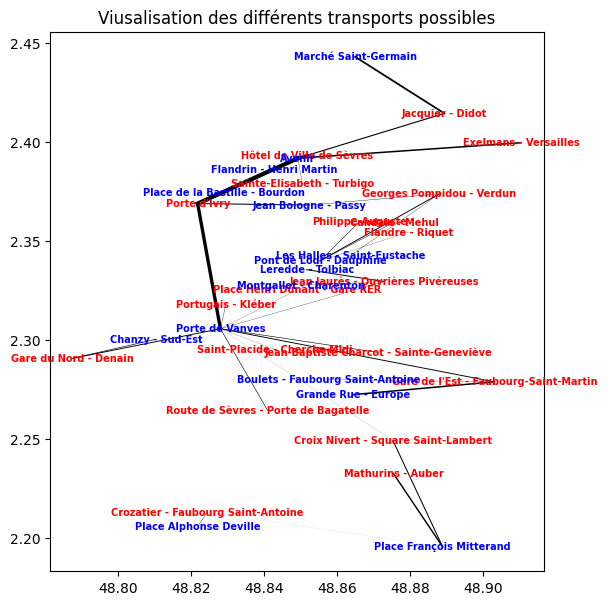

In [183]:
f = pl.figure(3, (14,7))
pl.clf()
pl.subplot(121)
#pl.imshow(paris_map, interpolation='bilinear')
for i in range(len(pos_station_remplissage)):
    for j in range(len(pos_station_vidage)):
        pl.plot([pos_station_remplissage.loc[i,'latitude'], pos_station_vidage.loc[j,'latitude']], [pos_station_remplissage.loc[i,'longitude'], pos_station_vidage.loc[j,'longitude']], '-k', lw=3. * ot_emd[i, j] / ot_emd.max())
for i in range(len(pos_station_vidage)):
    pl.text(pos_station_vidage.loc[i, 'latitude'], pos_station_vidage.loc[i, 'longitude'], stations_vidage.Station[i], color='red', fontsize=7, fontweight='bold', ha='center', va='center')
for i in range(len(pos_station_remplissage)):
    pl.text(pos_station_remplissage.loc[i, 'latitude'], pos_station_remplissage.loc[i, 'longitude'], stations_remplissage.Station[i], color='blue', fontsize=7, fontweight='bold', ha='center', va='center')

pl.title('Viusalisation des différents transports possibles')
pl.savefig('trajets_transports')

In [184]:
stations_remplissage.Station

0       Place de la Bastille - Bourdon
1                      Porte de Vanves
2                     Chanzy - Sud-Est
3              Flandrin - Henri Martin
4                               Avenir
5                 Jean Bologne - Passy
6          Les Halles - Saint-Eustache
7             Place François Mitterand
8                    Leredde - Tolbiac
9              Pont de Lodi - Dauphine
10                 Grande Rue - Europe
11    Boulets - Faubourg Saint-Antoine
12                Marché Saint-Germain
13              Place Alphonse Deville
14              Montgallet - Charenton
Name: Station, dtype: object

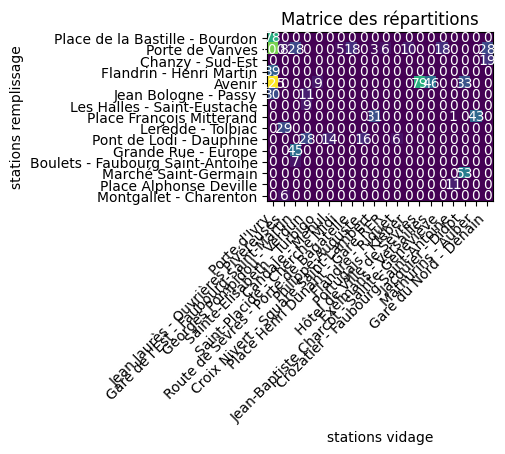

In [185]:
ax = pl.subplot(122)
im = pl.imshow(ot_emd)
for i in range(len(stations_remplissage)):
    for j in range((len(stations_vidage))):
        text = ax.text(j, i, '{0:g}'.format(ot_emd[i, j]), ha="center", va="center", color="w")
pl.xticks(ticks=np.arange(len(stations_vidage)), labels=stations_vidage['Station'], rotation=45, ha='right')
pl.yticks(ticks=np.arange(len(stations_remplissage)), labels=stations_remplissage['Station'])
pl.title('Matrice des répartitions')

pl.xlabel('stations vidage')
pl.ylabel('stations remplissage')
pl.savefig('Matrice_repartitions')

In [201]:
data_remp_2.rename(columns={'station_name': 'Station'}, inplace=True)

data_dispo_rempl=pd.DataFrame()
data_dispo_rempl['Station']=activite_station['Station']
data_dispo_rempl['VM_av']=data_remp_2.groupby('Station')['VM_Av'].mean().reset_index(drop=True)
data_dispo_rempl = pd.merge(data_dispo_rempl, activite_station, on='Station', how='inner')
data_dispo_rempl

,Station,VM_av,Nb_departs,Nb_arrivees,remplissage
0,Gare Saint-Lazare - Cour du Havre,2.870968,10057,10137,80
1,Gare de Lyon - Place Louis Armand,2.501946,9785,9866,81
2,Richard Lenoir - Place de la Bastille,13.108374,9659,9574,-85
3,Place Mireille Havet,1.239440,9042,8904,-138
4,Petites Ecuries - Faubourg Saint-Denis,1.508130,8188,8089,-99
...,...,...,...,...,...
1421,Combox Volante - atelier villeneuve,NaN,3,0,-3
1422,Stade Pershing,NaN,2,2,0
1423,station formation alfortville,NaN,1,0,-1
1424,Saint-Germain - Verdun,NaN,1,0,-1


In [200]:
data_dispo_rempl

0        2.870968
1        2.501946
2       13.108374
3        1.239440
4        1.508130
          ...    
1414     6.576832
1415     8.918519
1416     0.400351
1417     0.775416
1418     7.211223
Name: VM_Av, Length: 1419, dtype: float64

La variable frequ_appro correspond 

In [206]:
data_dispo_rempl['frequ_appro'] = (28 * data_dispo_rempl['VM_av']) / data_dispo_rempl['remplissage']
data_dispo_rempl.dropna()

,Station,VM_av,Nb_departs,Nb_arrivees,remplissage,frequ_appro
0,Gare Saint-Lazare - Cour du Havre,2.870968,10057,10137,80,1.004839
1,Gare de Lyon - Place Louis Armand,2.501946,9785,9866,81,0.864870
2,Richard Lenoir - Place de la Bastille,13.108374,9659,9574,-85,-4.318053
3,Place Mireille Havet,1.239440,9042,8904,-138,-0.251481
4,Petites Ecuries - Faubourg Saint-Denis,1.508130,8188,8089,-99,-0.426542
...,...,...,...,...,...,...
1414,Mairie de quartier du Plateau - Mont-Valérien,6.576832,70,141,71,2.593680
1415,Jules Guesde - Laennec,8.918519,68,93,25,9.988741
1416,Martyrs de Châteaubriant - Jean Grandel,0.400351,64,57,-7,-1.601405
1417,Sèvres Rive Gauche,0.775416,53,77,24,0.904652
